In [31]:
import torch 
import torch.nn.functional as F
from transformers import AutoModelForCausalLM, AutoTokenizer
import matplotlib.pyplot as plt 
import seaborn as sns
from circuitsvis.attention import attention_patterns, attention_pattern, attention_heads
from nnsight import LanguageModel

In [32]:
torch.set_grad_enabled(False)

In [33]:
# tokenizer = AutoTokenizer.from_pretrained("meta-llama/Llama-3.2-3B")
# model = AutoModelForCausalLM.from_pretrained("meta-llama/Llama-3.2-3B")
llm = LanguageModel("meta-llama/Llama-3.2-3B", device_map="auto", torch_dtype=torch.float32)

In [34]:
# Tokenize the text we want to use for ICL
base_sentence = "Macron is the president of France\nMacron is the president of Germany\nMacron is the president of"

# Tokenize the base sentence to get the begin of text token
token_sequence = llm.tokenizer(base_sentence)

# Get the ids of the tokens
tokens = token_sequence["input_ids"]

In [35]:
token_sequence

{'input_ids': [128000, 20122, 2298, 374, 279, 4872, 315, 9822, 198, 20122, 2298, 374, 279, 4872, 315, 10057, 198, 20122, 2298, 374, 279, 4872, 315], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

# Run the model #

In [36]:
# out = model(**token_sequence, return_dict=True, output_attentions=True)

In [37]:
sequence_length = len(tokens)

In [38]:
sequence_length

23

In [39]:
half_of_sequence = sequence_length // 2 - 1

In [40]:
induction_mask = torch.zeros(sequence_length, sequence_length).to(float)

In [41]:
induction_mask

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0

In [42]:
token_number_sequence = len(llm.tokenizer("Macron is the president of France")["input_ids"])
print(token_number_sequence)
tk_sequence = tokens
print(sequence_length)
print(llm.tokenizer.decode(tk_sequence))
print(tk_sequence)
for i in range(token_number_sequence + 1, sequence_length):
    if tk_sequence[i] not in tk_sequence[:i]:
        continue
    for j in range(i):
        if tk_sequence[i] == tk_sequence[j]:
            induction_mask[i, j + 1] = 1

8
23
<|begin_of_text|>Macron is the president of France
Macron is the president of Germany
Macron is the president of
[128000, 20122, 2298, 374, 279, 4872, 315, 9822, 198, 20122, 2298, 374, 279, 4872, 315, 10057, 198, 20122, 2298, 374, 279, 4872, 315]


In [43]:
induction_mask

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0.],
 

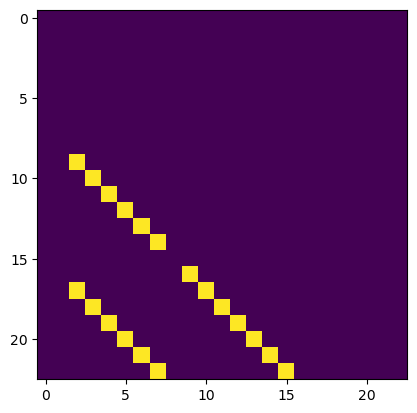

In [44]:
plt.imshow(induction_mask)
plt.show()

In [45]:
num_heads = llm.model.config.num_attention_heads
num_layers = llm.model.config.num_hidden_layers

induction_scores = torch.zeros(num_layers, num_heads)
tril = torch.tril_indices(sequence_length, sequence_length)

In [46]:
num_heads
num_layers

28

In [47]:
tril

tensor([[ 0,  1,  1,  2,  2,  2,  3,  3,  3,  3,  4,  4,  4,  4,  4,  5,  5,  5,
          5,  5,  5,  6,  6,  6,  6,  6,  6,  6,  7,  7,  7,  7,  7,  7,  7,  7,
          8,  8,  8,  8,  8,  8,  8,  8,  8,  9,  9,  9,  9,  9,  9,  9,  9,  9,
          9, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 10, 11, 11, 11, 11, 11, 11,
         11, 11, 11, 11, 11, 11, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12, 12,
         12, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 13, 14, 14, 14,
         14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 14, 15, 15, 15, 15, 15, 15,
         15, 15, 15, 15, 15, 15, 15, 15, 15, 15, 16, 16, 16, 16, 16, 16, 16, 16,
         16, 16, 16, 16, 16, 16, 16, 16, 16, 17, 17, 17, 17, 17, 17, 17, 17, 17,
         17, 17, 17, 17, 17, 17, 17, 17, 17, 18, 18, 18, 18, 18, 18, 18, 18, 18,
         18, 18, 18, 18, 18, 18, 18, 18, 18, 18, 19, 19, 19, 19, 19, 19, 19, 19,
         19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 20, 20, 20, 20, 20, 20,
         20, 20, 20, 20, 20,

In [48]:
induction_flat = induction_mask[tril[0], tril[1]].flatten()

In [49]:
induction_flat # this is an array of the values of the lower triangle matrix of the induction mask


tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
        0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
        0., 0., 0., 0., 0., 0., 0., 1., 

In [50]:
induction_flat.shape

torch.Size([276])

In [51]:
llm.config.output_attentions = True

In [52]:
with llm.trace(base_sentence):
    output = llm.output.save()

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
/opt/miniconda3/envs/helmholtz/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:777: UserWarning: `return_dict_in_generate` is NOT set to `True`, but `output_attentions` is. When `return_dict_in_generate` is not `True`, `output_attentions` is ignored.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

Some parameters are on the meta device because they were offloaded to the disk.
LlamaModel is using LlamaSdpaAttention, but `torch.nn.functional.scaled_dot_product_attention` does not support `output_attentions=True`. Falling back to the manual attention implementation, but specifying the manual implementation will be required from Transformers version v5.0.0 onwards. This warning can be removed using the argument `attn_implementation="eager"` when loading the model.
Starting from v4.46, the `logits` model output will have the same type as the model (except at train time, where it will always be FP32)


In [53]:
output.attentions

(tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [9.9015e-01, 9.8457e-03, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [9.9637e-01, 1.9424e-03, 1.6905e-03,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [8.3658e-03, 3.6882e-06, 1.8035e-06,  ..., 7.0827e-02,
            0.0000e+00, 0.0000e+00],
           [9.5338e-01, 1.3222e-04, 1.6947e-04,  ..., 1.2043e-02,
            6.4934e-03, 0.0000e+00],
           [7.8528e-02, 4.8813e-07, 6.8740e-05,  ..., 2.6897e-02,
            6.2453e-01, 2.6638e-01]],
 
          [[1.0000e+00, 0.0000e+00, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [8.2333e-01, 1.7667e-01, 0.0000e+00,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           [2.2932e-01, 7.3562e-01, 3.5064e-02,  ..., 0.0000e+00,
            0.0000e+00, 0.0000e+00],
           ...,
           [2.8931e-02, 7.1502e-06, 1.

In [54]:
with llm.trace(base_sentence):
    tk = llm.inputs[1]["input_ids"][0].save()
    output = llm.output.save()
    for layer in range(num_layers):
        for head in range(num_heads):
            pattern = llm.output.attentions[layer][0][head].cpu().to(float).save()
            pattern_flat = pattern[tril[0], tril[1]].flatten()
            score = (induction_flat @ pattern_flat) / pattern_flat.sum()
            induction_scores[layer, head] = score

In [55]:
induction_scores.shape

torch.Size([28, 24])

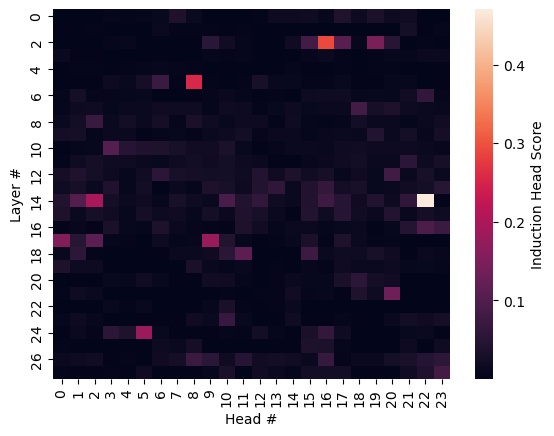

In [56]:
fig,ax = plt.subplots()
sns.heatmap(induction_scores,  cbar_kws={'label': 'Induction Head Score'},ax=ax)
ax.set_ylabel("Layer #")
ax.set_xlabel("Head #")
plt.show()

In [57]:
layer, head = torch.unravel_index(induction_scores.argmax(), induction_scores.shape)

In [58]:
print(layer, head)

tensor(14) tensor(22)


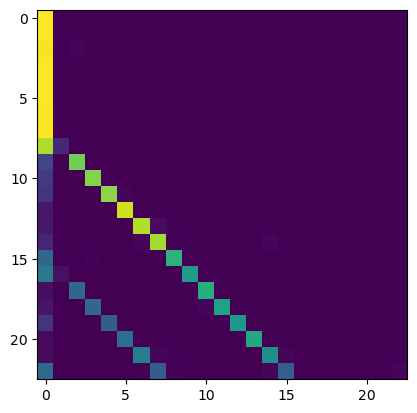

In [59]:
plt.imshow(output.attentions[layer][0][head].cpu().float())
plt.show()

In [60]:
output.attentions[0][0][head].shape

torch.Size([23, 23])

In [61]:
token_labels = [llm.tokenizer.decode([tok]) for tok in tk]
print(token_labels)
attention_heads(
    output.attentions[layer][0][head], 
    token_labels
)

['<|begin_of_text|>', 'Mac', 'ron', ' is', ' the', ' president', ' of', ' France', '\n', 'Mac', 'ron', ' is', ' the', ' president', ' of', ' Germany', '\n', 'Mac', 'ron', ' is', ' the', ' president', ' of']


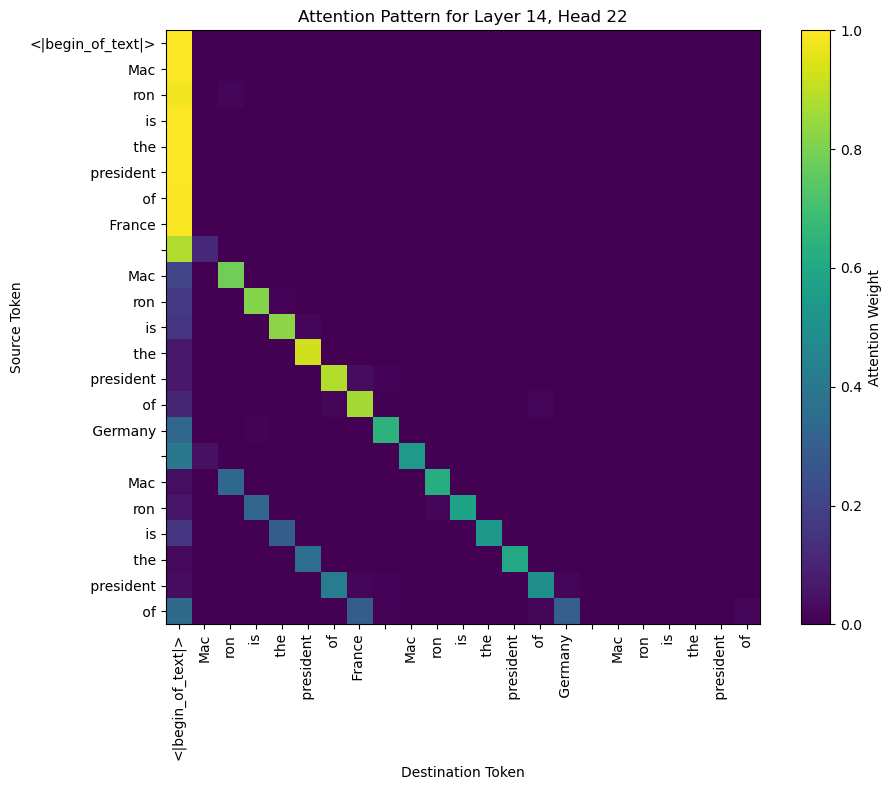

In [63]:


# Create a matplotlib figure for the attention pattern
plt.figure(figsize=(10, 8))
plt.imshow(output.attentions[layer][0][head].cpu().float())
plt.colorbar(label='Attention Weight')
plt.title(f"Attention Pattern for Layer {layer}, Head {head}")
plt.ylabel("Source Token")
plt.xlabel("Destination Token")

# Add token labels if not too many
if len(tk) < 30:  # Only add labels if there aren't too many tokens
    plt.xticks(range(len(token_labels)), token_labels, rotation=90)
    plt.yticks(range(len(token_labels)), token_labels)

# Save as PDF
plt.tight_layout()
plt.savefig(f"attention_pattern_layer{layer}_head{head}.pdf", format="pdf", bbox_inches="tight", dpi=300)

# Also display the interactive visualization
attention_pattern(
    tk,
    output.attentions[layer][0][head],
    show_axis_labels=True
)